In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split ,  GridSearchCV
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math
from copy import deepcopy as dc

In [2]:
data = pd.read_csv('nifty.csv', date_parser = True)

In [3]:
data = data[['Local Time', 'Close']]

In [4]:
data['Local Time'] = pd.to_datetime(data['Local Time'])

In [5]:
def dataframe_transform_lstm(df, n_steps):
    df = dc(df)

    df.set_index('Local Time', inplace=True)

    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)

    df.dropna(inplace=True)

    return df

lookback = 5
transformdf = dataframe_transform_lstm(data, lookback)
transformdf

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5)
Local Time,,,,,,
2023-10-09 13:50:00,212.15,212.28,212.17,212.12,212.12,212.12
2023-10-09 13:45:00,212.11,212.15,212.28,212.17,212.12,212.12
2023-10-09 13:40:00,212.12,212.11,212.15,212.28,212.17,212.12
2023-10-09 13:35:00,212.10,212.12,212.11,212.15,212.28,212.17
2023-10-09 13:30:00,211.81,212.10,212.12,212.11,212.15,212.28
...,...,...,...,...,...,...
2023-10-09 13:05:00,213.86,214.04,213.47,213.78,213.98,213.88
2023-10-09 13:00:00,214.34,213.86,214.04,213.47,213.78,213.98
2023-10-09 12:55:00,214.56,214.34,213.86,214.04,213.47,213.78


In [6]:
transformdf_np = transformdf.to_numpy()
transformdf_np

array([[212.15, 212.28, 212.17, 212.12, 212.12, 212.12],
       [212.11, 212.15, 212.28, 212.17, 212.12, 212.12],
       [212.12, 212.11, 212.15, 212.28, 212.17, 212.12],
       ...,
       [214.56, 214.34, 213.86, 214.04, 213.47, 213.78],
       [215.03, 214.56, 214.34, 213.86, 214.04, 213.47],
       [214.85, 215.03, 214.56, 214.34, 213.86, 214.04]])

In [7]:
scaler = StandardScaler()
transformdf_np = scaler.fit_transform(transformdf_np)

In [8]:
X = transformdf_np[:, 1:]
y = transformdf_np[:, 0]

X.shape, y.shape

((35692, 5), (35692,))

In [9]:
X = dc(np.flip(X, axis=1))
X

array([[-1.25456116, -1.25457173, -1.25458508, -1.25022503, -1.24061761],
       [-1.25456116, -1.25457173, -1.25021047, -1.24060082, -1.25199177],
       [-1.25456116, -1.25019715, -1.24058632, -1.25197489, -1.25549152],
       ...,
       [-1.10932568, -1.13645795, -1.08659997, -1.10236213, -1.06038094],
       [-1.13644797, -1.08658769, -1.10234858, -1.06036556, -1.04113236],
       [-1.08657796, -1.10233619, -1.0603523 , -1.04111713, -1.0000104 ]])

In [10]:
split_index = int(len(X) * 0.95)

split_index

33907

In [11]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((33907, 5), (1785, 5), (33907,), (1785,))

In [12]:
svr = SVR()

# Define the hyperparameter grid for GridSearchCV
param_grid = {
    'kernel': ['rbf'],
    'C': [0.1,0.2,1,2,3,4,5,6,7,8,9,10],
    'gamma': ['scale','auto'] + [0.01, 0.1, 1]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the model to the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

In [13]:
best_params = grid_search.best_params_

In [14]:
best_svr = SVR(**best_params)
best_svr.fit(X_train, y_train)

SVR(C=7, gamma=0.1)

In [15]:
y_pred = best_svr.predict(X_test)
y_pred_train=best_svr.predict(X_train)

## Perfomance Metrics of Testing Data

In [16]:
mean_squared_error(y_test, y_pred)

0.0002873744859708105

In [17]:
math.sqrt(mean_squared_error(y_test,y_pred))

0.01695212334696779

In [18]:
r2_score(y_test, y_pred)

0.9891661044391402

## Perfomance Metrics of Training Data

In [19]:
mean_squared_error(y_train, y_pred_train)

0.00039963819380354094

In [20]:
math.sqrt(mean_squared_error(y_train, y_pred_train))

0.01999095279879228

In [21]:
r2_score(y_train, y_pred_train)

0.9995930318932043

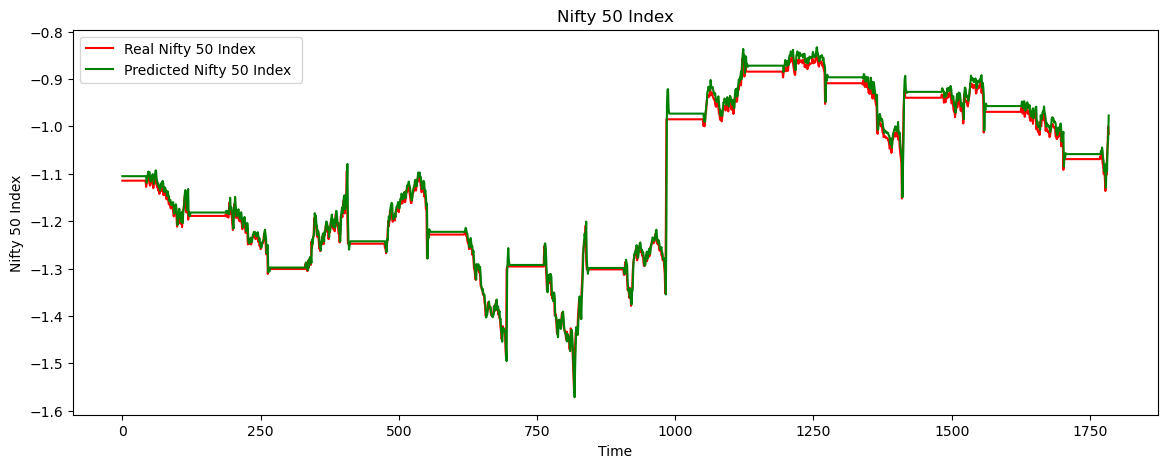

In [22]:
# Visualising the results
plt.figure(figsize=(14,5))
plt.plot(y_test, color = 'red', label = 'Real Nifty 50 Index ')
plt.plot(y_pred, color = 'green', label = 'Predicted Nifty 50 Index ')
plt.title('Nifty 50 Index')
plt.xlabel('Time')
plt.ylabel('Nifty 50 Index')
plt.legend()
plt.show()